In [1]:
#Загружаем библиотеки
import numpy as np
import pandas as pd
import random
import math


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2, f1_score as f1
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings

import os

In [2]:
warnings.filterwarnings('ignore')

In [3]:


matplotlib.rcParams.update({'font.size':14})

#Создаем переменные и присваиваем им значения путей к тестовому и тренировочному файлу 
train_path = 'course_project_train.csv'
test_path =  'course_project_test.csv'

#Читаем файл с тестовыми данными
test_df = pd.read_csv(test_path)
test_df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


In [4]:
#Читаем файл с тренировочными данными
train_df = pd.read_csv(train_path)

train_df.head(5)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [5]:
test_df.shape,train_df.shape

((2500, 16), (7500, 17))

In [6]:
columns = [i for i in train_df.columns]
train_df['ID'] = train_df.index.tolist()
columns

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score',
 'Credit Default']

In [7]:
train_df.iloc[0]

Home Ownership                            Own Home
Annual Income                               482087
Years in current job                           NaN
Tax Liens                                        0
Number of Open Accounts                         11
Years of Credit History                       26.3
Maximum Open Credit                         685960
Number of Credit Problems                        1
Months since last delinquent                   NaN
Bankruptcies                                     1
Purpose                         debt consolidation
Term                                    Short Term
Current Loan Amount                          1e+08
Current Credit Balance                       47386
Monthly Debt                                  7914
Credit Score                                   749
Credit Default                                   0
ID                                               0
Name: 0, dtype: object

In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

__Обработка пропусков__

In [9]:
"Тестовая выборка ",len(test_df) - test_df.count(), '',"Тренировочная выбока",len(train_df) - train_df.count()

('Тестовая выборка ',
 Home Ownership                     0
 Annual Income                    513
 Years in current job              86
 Tax Liens                          0
 Number of Open Accounts            0
 Years of Credit History            0
 Maximum Open Credit                0
 Number of Credit Problems          0
 Months since last delinquent    1358
 Bankruptcies                       3
 Purpose                            0
 Term                               0
 Current Loan Amount                0
 Current Credit Balance             0
 Monthly Debt                       0
 Credit Score                     513
 dtype: int64,
 '',
 'Тренировочная выбока',
 Home Ownership                     0
 Annual Income                   1557
 Years in current job             371
 Tax Liens                          0
 Number of Open Accounts            0
 Years of Credit History            0
 Maximum Open Credit                0
 Number of Credit Problems          0
 Months since last de

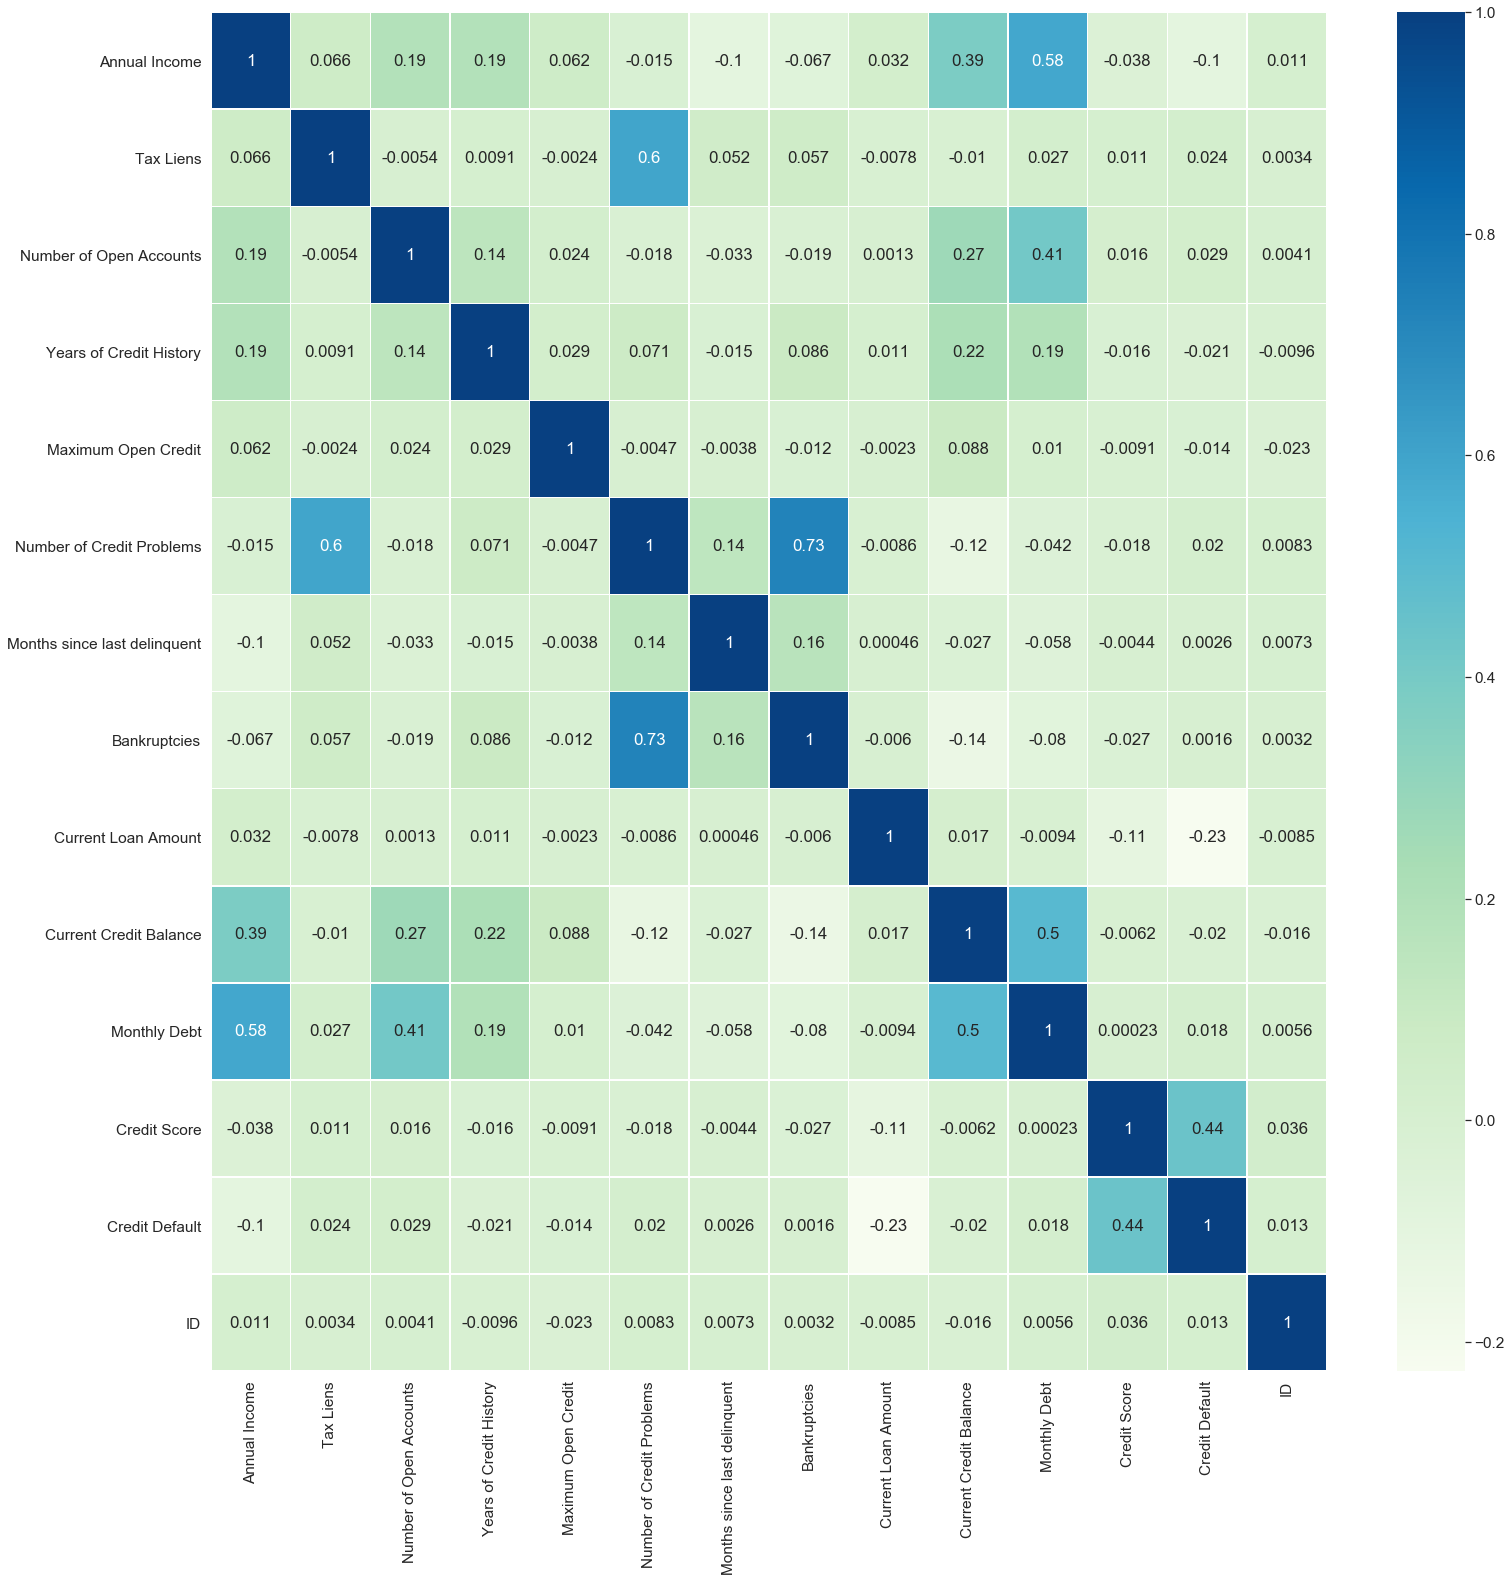

In [10]:

df_corr = train_df.corr()
plt.figure(figsize = (25,25))

sns.set(font_scale=1.4)
sns.heatmap(df_corr, annot=True, linewidths=.5, cmap='GnBu')

# plt.title('Correlation matrix')
plt.show()

In [11]:
train_df['Years in current job'].unique()

array([nan, '10+ years', '8 years', '6 years', '7 years', '5 years',
       '1 year', '< 1 year', '4 years', '3 years', '2 years', '9 years'],
      dtype=object)

In [12]:
# Процедура создает поле идентификатор для заданного разреза учета, категориальный признак
def add_id_col(col):
    new_col = f'{col}_id'
    train_df[new_col]=0
    columns.append(new_col)
    for k, v in enumerate(train_df[col].unique()):
        train_df.loc[train_df[col]==v, new_col] = k+1

In [13]:
#Для категориальных признаков введем идентификаторы
add_id_col('Home Ownership')
add_id_col('Purpose')
add_id_col('Term')

In [14]:
##Чистим года
def replace_str_to_int(arr,col ='Years in current job' , new_col = 'Years in current job'):
    new = {}
    for word in arr:
        if pd.isna(word) == True or type(word) in (np.float64, np.int):
            new['nan'] = -1
            train_df.loc[train_df[col].isna(), new_col] = -1
            continue
        i = ''
        for item in word:
            if ord(item) >=48 and ord(item) <=57:
                i = f'{i}{item}'
                new[word] = i
        
        train_df.loc[train_df[col]==word, new_col] = i
                
    train_df[col] = train_df[col].astype(float)
    
#     оставим массив для возможного мапинга со старыми значениями
    return new

In [15]:
##Чистим года
replace_str_to_int(train_df['Years in current job'].unique())

{'nan': -1,
 '10+ years': '10',
 '8 years': '8',
 '6 years': '6',
 '7 years': '7',
 '5 years': '5',
 '1 year': '1',
 '< 1 year': '1',
 '4 years': '4',
 '3 years': '3',
 '2 years': '2',
 '9 years': '9'}

In [16]:
# train_df.loc[train_df['Years in current job']=='10+ years']
# train_df.loc[train_df['Years in current job'].notna()==False, 'Years in current job']=-1
#train_df

Гипотиза - если человеку дали кредит , значит он работал.
Вычислим моду доли выданного кредита (месячный кредит * 12 месяцев / годовую зарплату)
Полученный процент используем для заполнения "Годовой доход"  = Ежемесячный Кредит * 12 (100-мода) / мода 
 и "Текущая сумма кредита"

In [17]:
tip_rate = train_df.loc[(train_df['Annual Income'].notna()) & (train_df['Current Loan Amount'] < 99999999.0)
             ].assign(tip_rate=train_df['Monthly Debt'] * 12 * 100 / train_df['Current Loan Amount']
                     )
df  = tip_rate.round(0)

mean = round(df['tip_rate'].mean(), 2)
median = df['tip_rate'].median()
mode = df['tip_rate'].mode()[0]

mean, median, mode

(93.02, 68.0, 53.0)

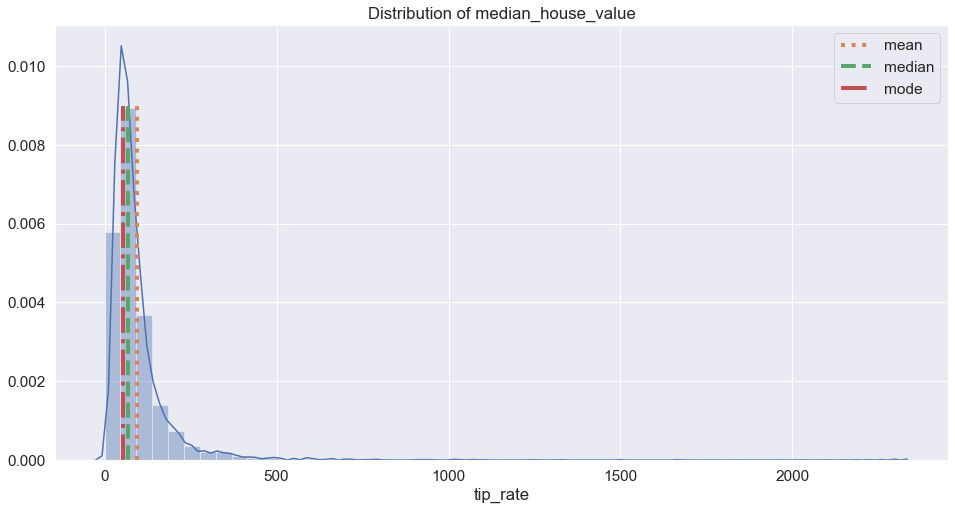

In [18]:
plt.figure(figsize = (16, 8))

sns.distplot(df['tip_rate'])

y = np.linspace(0, 0.009, 100)
plt.plot([mean] * 100, y, label='mean', linestyle=':', linewidth=4)
plt.plot([median] * 100, y, label='median', linestyle='--', linewidth=4)
plt.plot([mode] * 100, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of median_house_value')
plt.legend()
plt.show()

In [19]:
#используем ранее полученную моду и высчитаем годовой доход
df2 = train_df.loc[train_df['Annual Income'].isna()
            ].assign(Annual_Income=train_df['Monthly Debt']*12*(100-53)/53
                    ).round(0)


train_df = train_df.merge(df2, on='ID', how='left',suffixes=('', '_'))[columns+['Annual_Income']+['ID']]
train_df['Annual Income'] = train_df['Annual_Income'].combine_first(train_df['Annual Income'])
train_df = train_df[columns+['ID']]
train_df

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default,Home Ownership_id,Purpose_id,Term_id,ID
0,Own Home,482087.0,-1.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,...,Short Term,99999999.0,47386.0,7914.0,749.0,0,1,1,1,0
1,Own Home,1025487.0,10.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,...,Long Term,264968.0,394972.0,18373.0,737.0,1,1,1,2,1
2,Home Mortgage,751412.0,8.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,...,Short Term,99999999.0,308389.0,13651.0,742.0,0,2,1,1,2
3,Own Home,805068.0,6.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,...,Short Term,121396.0,95855.0,11338.0,694.0,0,1,1,1,3
4,Rent,776264.0,8.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,...,Short Term,125840.0,93309.0,7180.0,719.0,0,3,1,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,Rent,402192.0,1.0,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,...,Short Term,129360.0,73492.0,1900.0,697.0,0,3,2,1,7495
7496,Home Mortgage,1533984.0,1.0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,...,Long Term,444048.0,456399.0,12783.0,7410.0,1,2,1,2,7496
7497,Rent,1878910.0,6.0,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,...,Short Term,99999999.0,477812.0,12479.0,748.0,0,3,5,1,7497
7498,Home Mortgage,394992.0,-1.0,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,...,Short Term,615274.0,476064.0,37118.0,NaN,0,2,1,1,7498


In [20]:
# 1/0

In [21]:
tmp_features = ['Years of Credit History', 'Number of Open Accounts', 'Maximum Open Credit',
                    'Monthly Debt', 'Number of Credit Problems'
               ]
tmp_df = train_df.loc[train_df['Bankruptcies'].notna(), tmp_features] 


tmp_target = train_df.loc[train_df['Bankruptcies'].notna(), 'Bankruptcies']

X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(tmp_df, tmp_target, test_size=0.25,
                                                                    shuffle=True, random_state=17)
model = RandomForestRegressor(n_jobs=2,
                                  n_estimators=100,
                                  min_samples_split=25,
                                  max_features=2,
                                  random_state=17)
model.fit(X_train_tmp, y_train_tmp)
predict_tpm = model.predict(X_test_tmp)

annual_income_mean = train_df.loc[train_df['Bankruptcies'].notna(), 'Bankruptcies'].shape

print('r2 предикта:', r2(y_test_tmp, predict_tpm))
print('r2 mean значения:', r2(y_test_tmp, [annual_income_mean for val in range(X_test_tmp.shape[0])]))

r2 предикта: 0.7142289797570005
r2 mean значения: -505473164.9337568


In [22]:
model = RandomForestRegressor(n_jobs=2,
                                  n_estimators=100,
                                  min_samples_split=25,
                                  max_features=2,
                                  random_state=17)
model.fit(tmp_df, tmp_target)

train_df['Bankruptcies_pred'] = model.predict(train_df.loc[:, tmp_features]).round()
train_df['dif'] = train_df['Bankruptcies_pred'] / train_df['Bankruptcies']
train_df.loc[:, ['Bankruptcies_pred', 'Bankruptcies', 'dif']].head(10)

,Bankruptcies_pred,Bankruptcies,dif
0,1.0,1.0,1.0
1,0.0,0.0,NaN
2,0.0,0.0,NaN
3,1.0,1.0,1.0
4,1.0,0.0,inf
5,0.0,0.0,NaN
6,0.0,0.0,NaN
7,0.0,0.0,NaN
8,1.0,1.0,1.0
9,0.0,0.0,NaN


In [23]:
train_df['Bankruptcies'] = train_df['Bankruptcies_pred'].combine_first(train_df['Bankruptcies'])
train_df = train_df[columns+['ID']]

In [24]:
#Гипотиза : 100 млн долга быть не может. Предположим,  что кредит выдан на 1 год
#Можно в принципи подумать и тип домовладения включить влияющим фактором))))
IDs = train_df.loc[(train_df['Current Loan Amount'] == 99999999.0)]['ID']

train_df.loc[train_df['ID'].isin(IDs), 'Current Loan Amount'
            ] = train_df.loc[train_df['ID'].isin(IDs), 'Monthly Debt'
                            ].map(lambda x: x * 12 )


In [25]:
#Ошибочно оттолкнулся от таргета
#Гипотиза : для неучтенных банкротов при кредитном дефолте ставим 1 если нет дефолта то ноль
# train_df.loc[(train_df['Bankruptcies'].isna()) & (train_df['Credit Default']==1), ['Bankruptcies']] = 1
# train_df.loc[(train_df['Bankruptcies'].isna()) & (train_df['Credit Default']==0), ['Bankruptcies']] = 0

In [26]:
# Ошибочно
#Гипотиза : не можт быть не заполненным поле месяцы непросрочки
# Для Банкротов и дефолтов ставим среднее по полю Months since last delinquent 
# Для остальных ноль месяцев
# train_df.loc[(train_df['Months since last delinquent'].isna()
#              ) & ((train_df['Bankruptcies']>0)|(train_df['Credit Default']==1)
#                  )
#             , ['Months since last delinquent']] = round(train_df.loc[train_df['Months since last delinquent'
#                                                                              ].notna()
#                                                                     ]['Months since last delinquent'].mean())

# train_df.loc[(train_df['Months since last delinquent'].isna()
#              ) & ((train_df['Bankruptcies']==0)&(train_df['Credit Default']==0)
#                  )
#             , ['Months since last delinquent']] = 0

In [27]:
# Проверил : у банкротов и не банкров мода однв
train_df.loc[(train_df['Months since last delinquent'].isna()), 'Months since last delinquent'
            ] = train_df.loc[(train_df['Months since last delinquent'].notna())
                            ]['Bankruptcies'].mode()[0]

In [28]:
# Проверил : у банкротов и не банкров мода одна
# train_df.loc[(train_df['Credit Score'].isna()), 'Credit Score'
#             ] = 
train_df.loc[(train_df['Credit Score'].notna())]['Credit Score'].mode()

0    740.0
dtype: float64

In [29]:
# Проверил : у банкротов и не банкров мода одна
train_df.loc[(train_df['Credit Score'].isna()), 'Credit Score'
            ] = train_df.loc[(train_df['Credit Score'].notna())]['Credit Score'].mode()[0]

In [30]:
len(train_df) - train_df.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
Home Ownership_id               0
Purpose_id                      0
Term_id                         0
ID                              0
dtype: int64

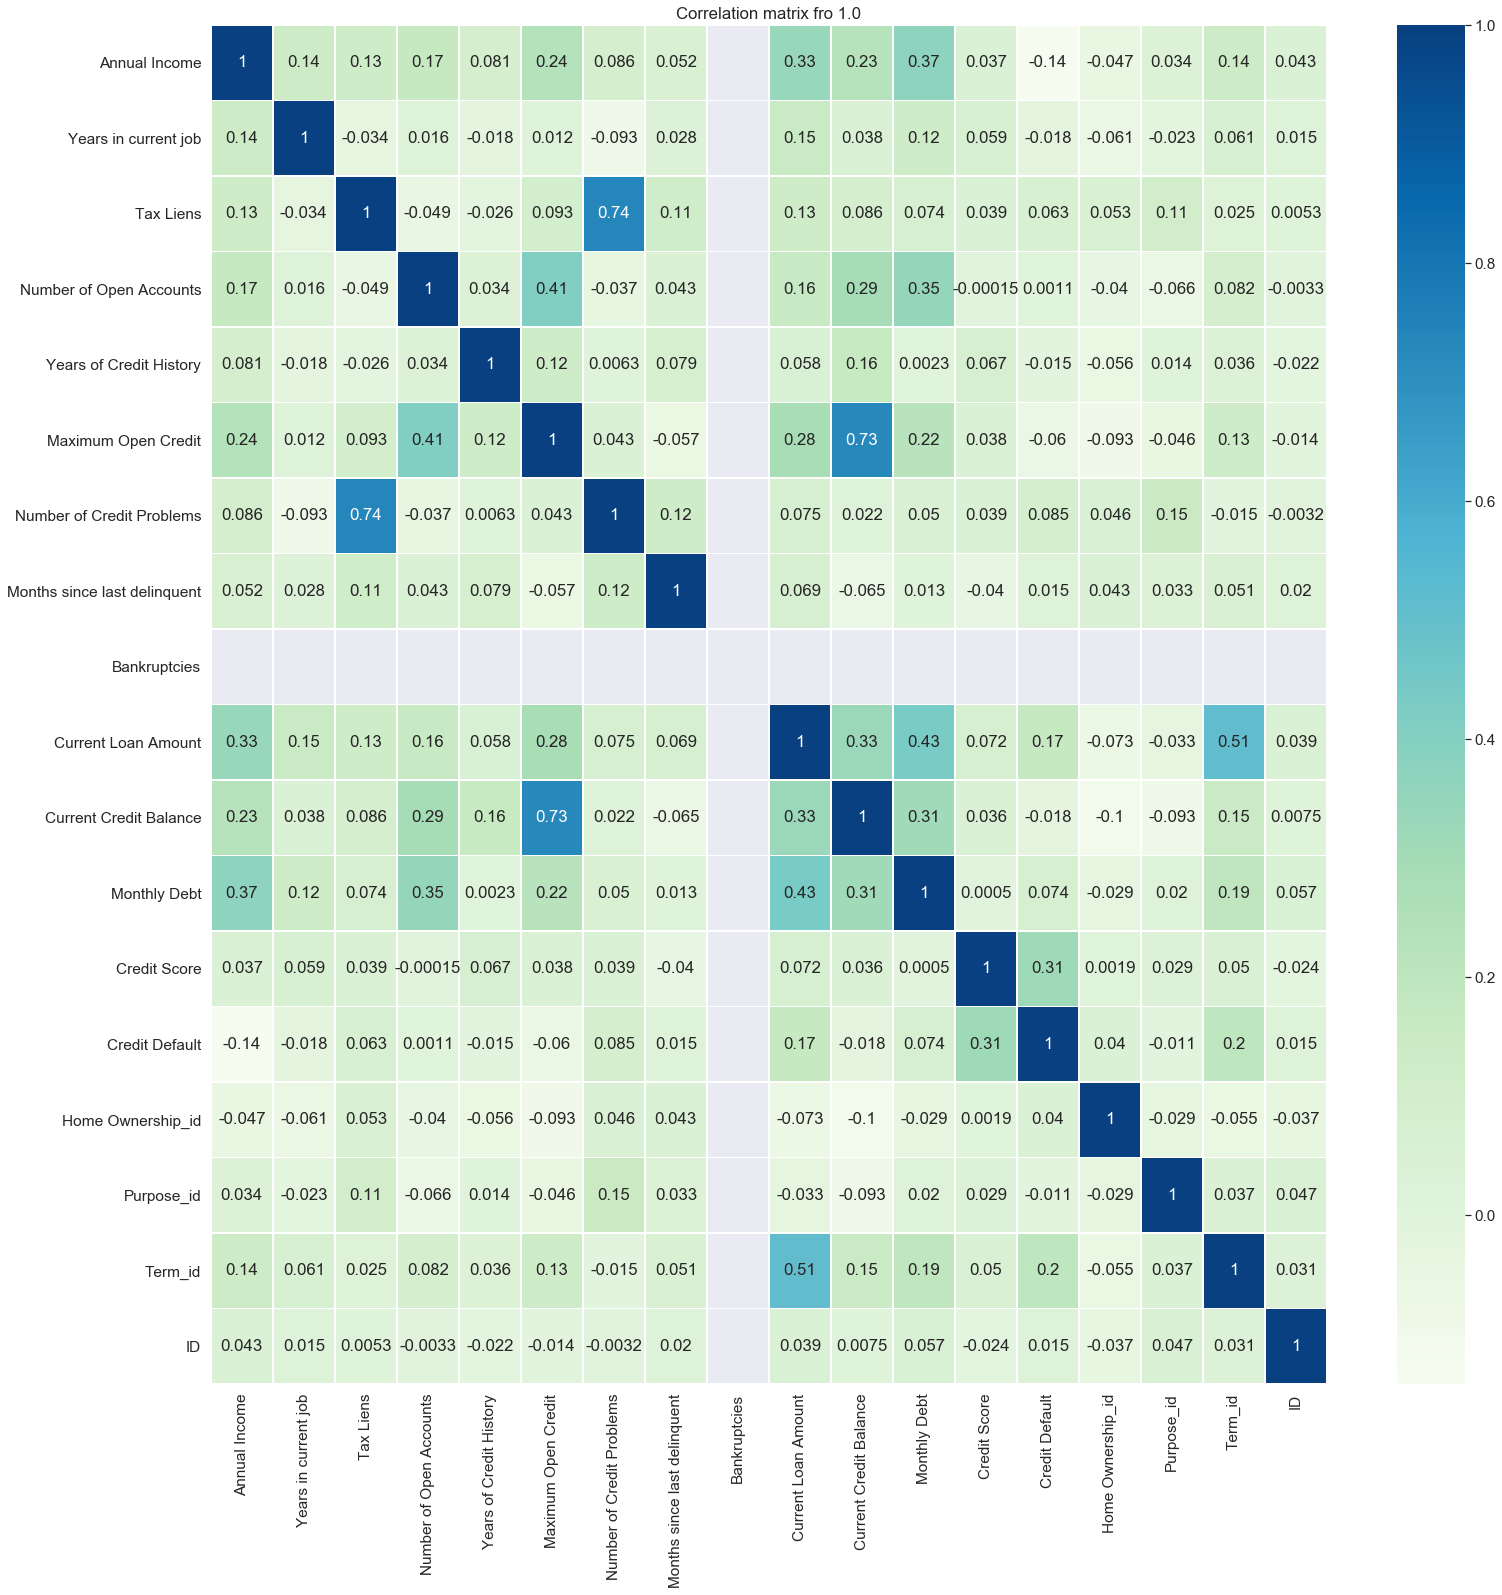

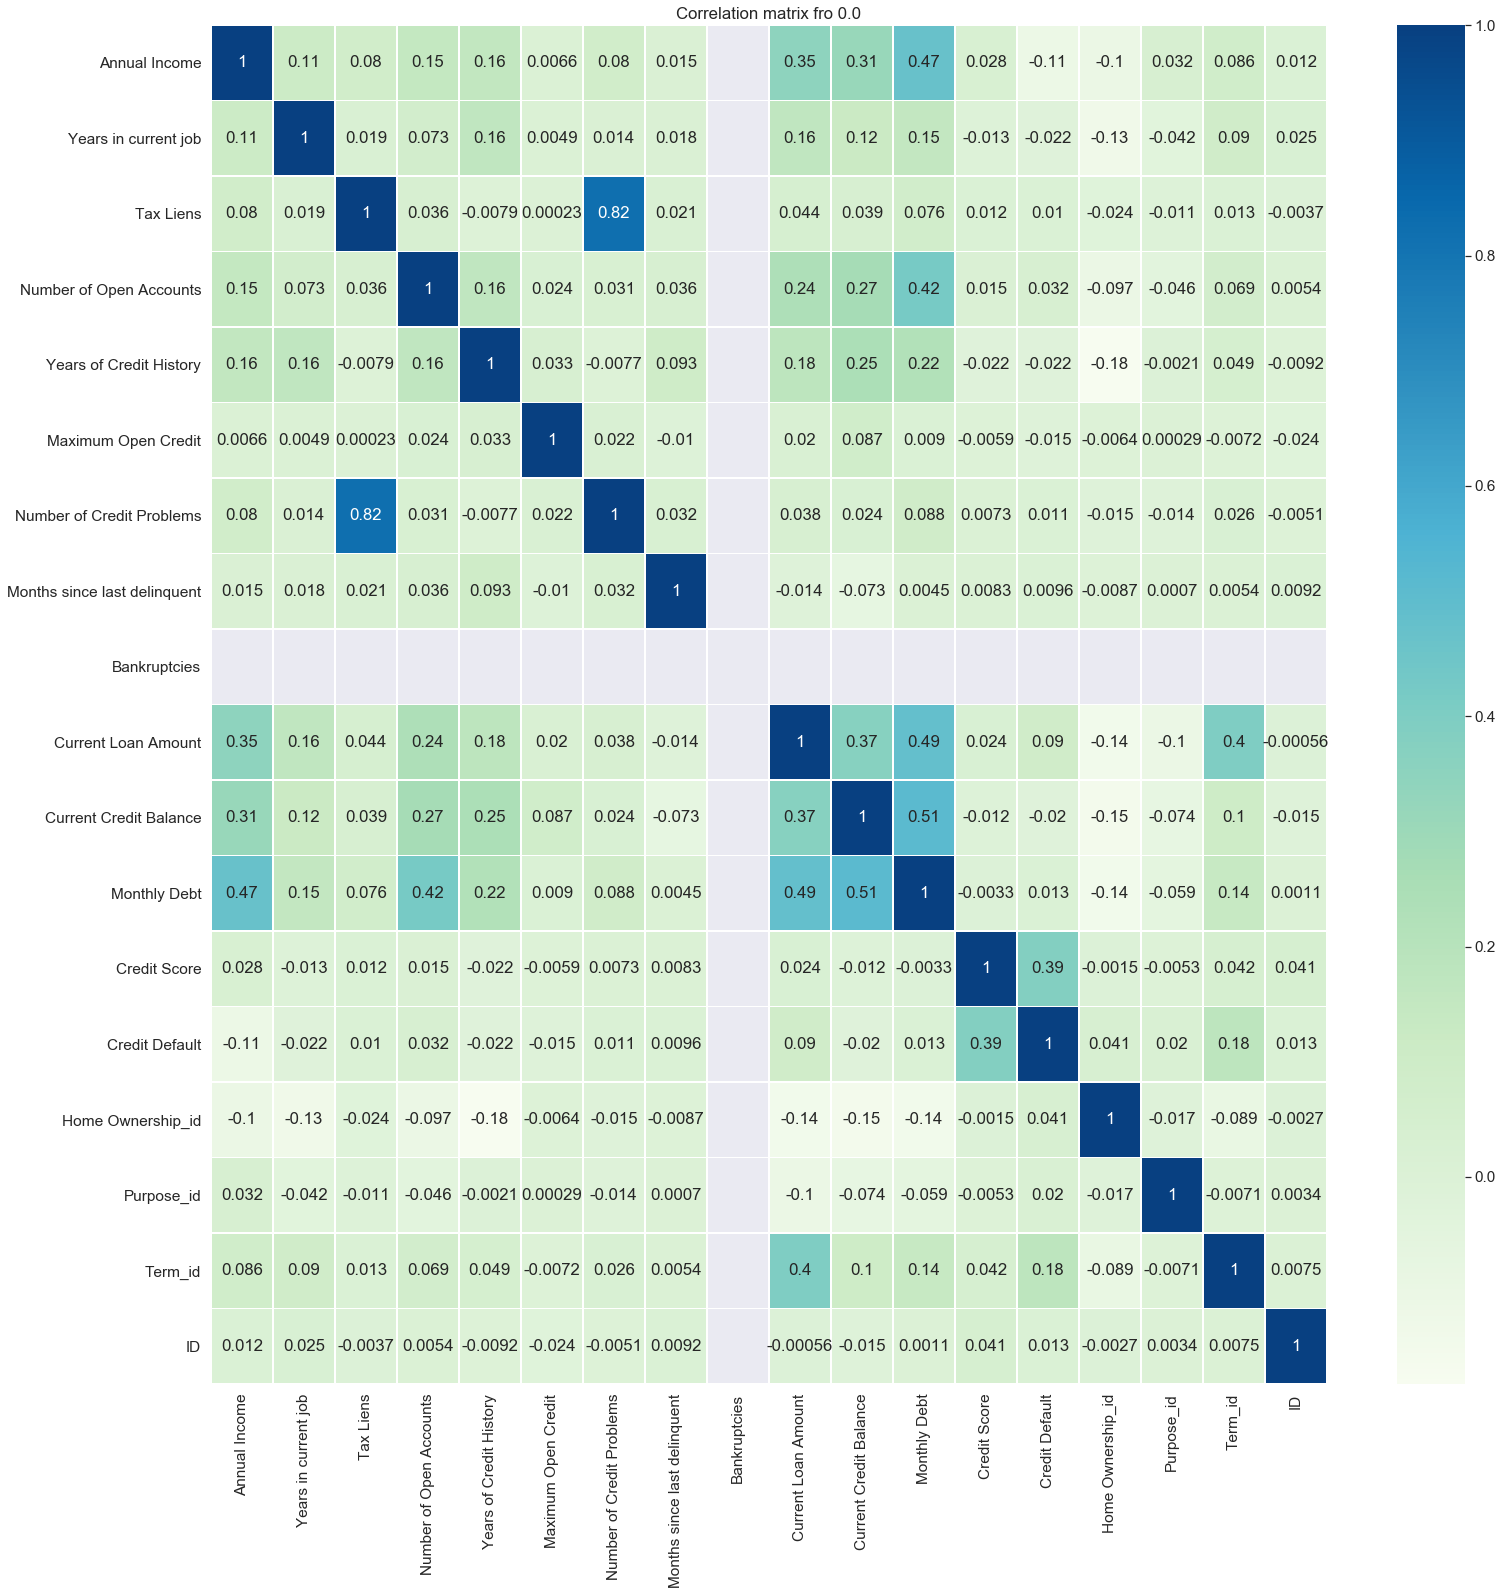

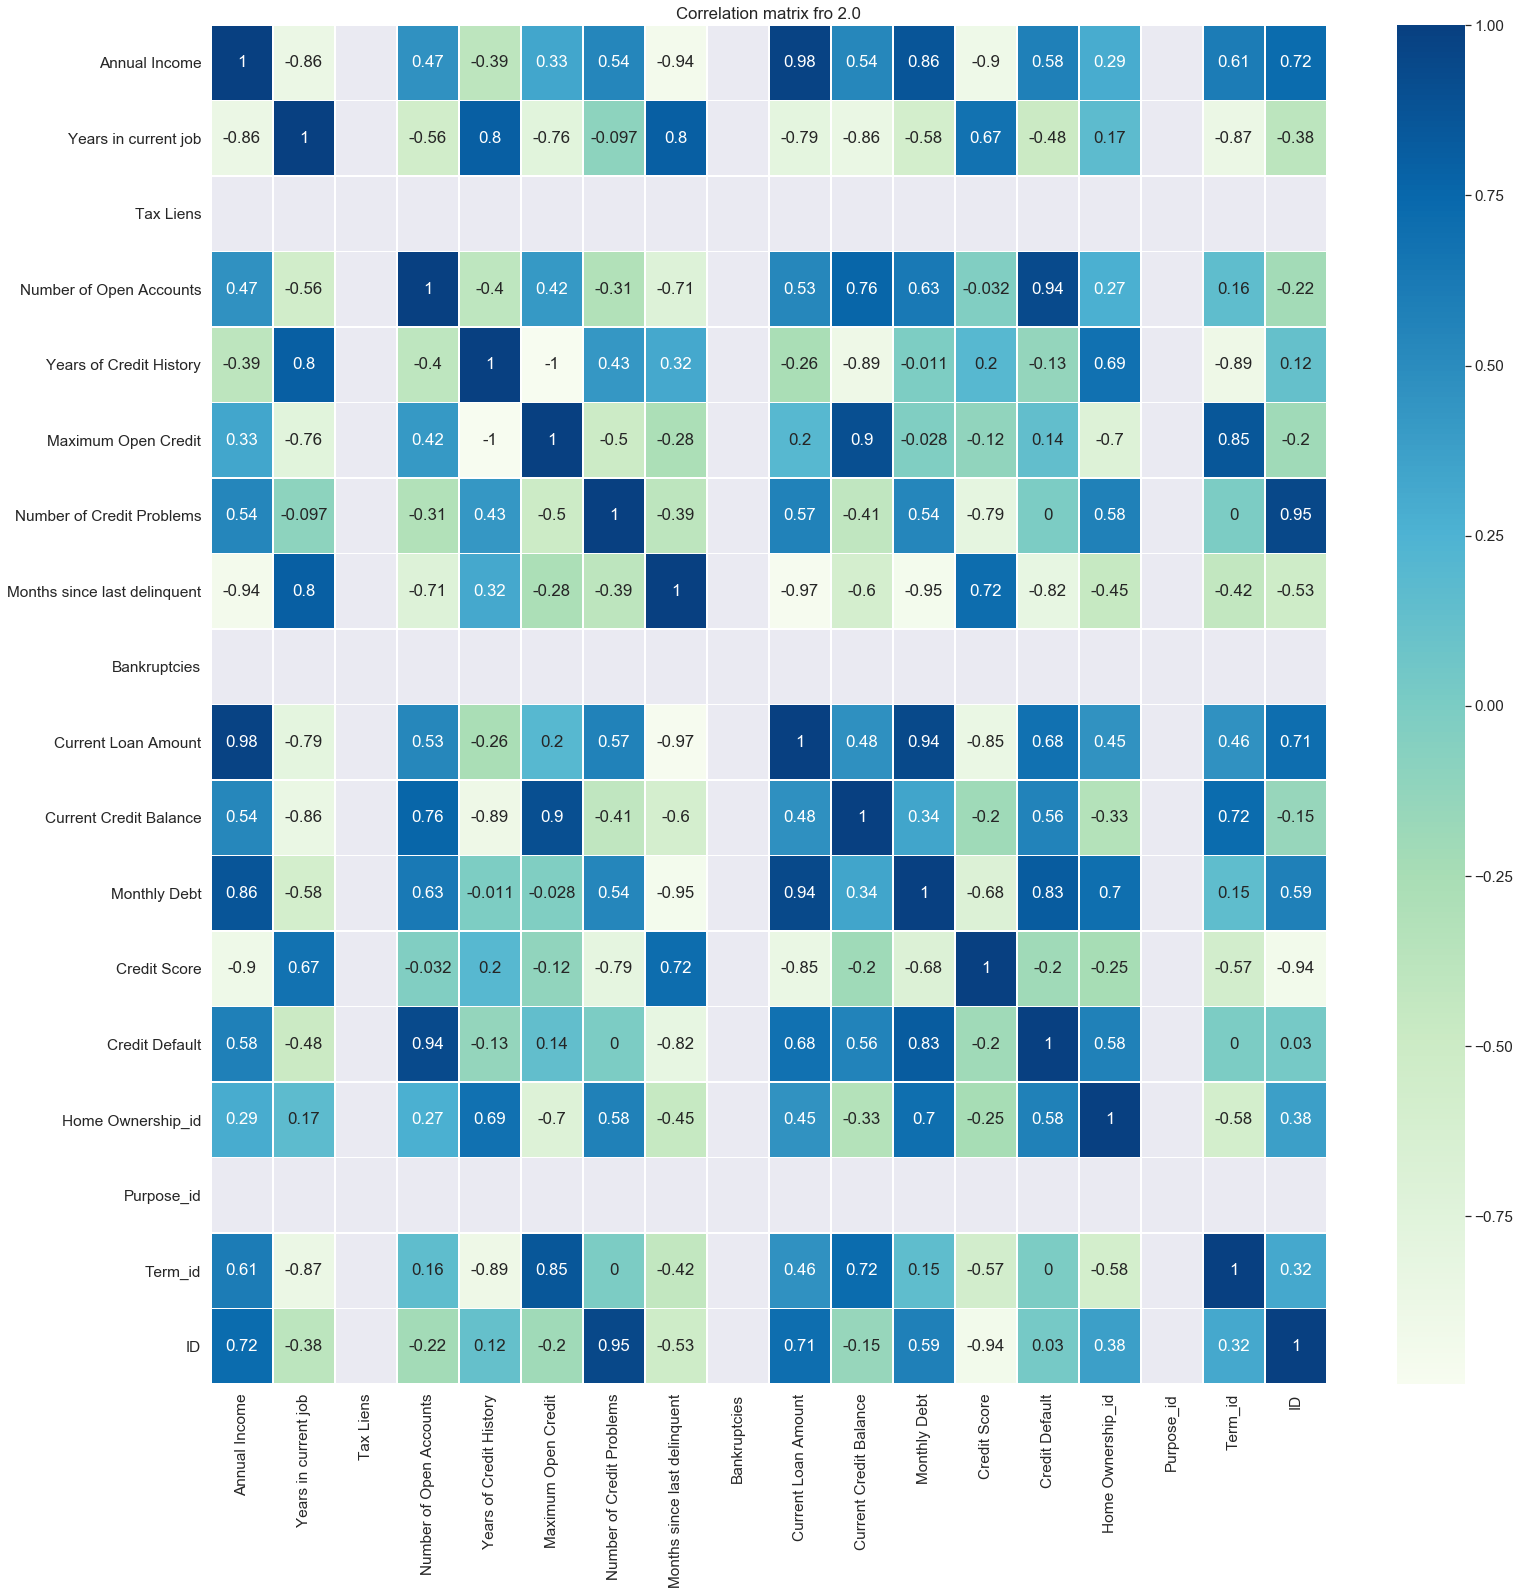

In [31]:
#Здесь строил кореляцию в разбивке по группам . Не помогло((
col = 'Bankruptcies'
for k, v in enumerate(train_df[col].unique()):
    df_corr = train_df.loc[(train_df['Credit Score'].notna())&(train_df[col]==v)].corr()
    plt.figure(figsize = (25,25))

    sns.set(font_scale=1.4)
    sns.heatmap(df_corr, annot=True, linewidths=.5, cmap='GnBu')

    plt.title(f'Correlation matrix for {v}')
    plt.show()

In [32]:
train_df['Bankruptcies'].value_counts()

0.0    6508
1.0     988
2.0       4
Name: Bankruptcies, dtype: int64

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7500 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   float64
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [34]:
# from sklearn.decomposition import PCA

# pca = PCA(n_components=1)

# result_ = pca.fit_transform(train_df)

# print(result_)

Home Ownership                - Домоволадение

Annual Income                 - Годовой доход

Years in current job          - Годы на текущем месте работы

Tax Liens                     - Налоговые льготы

Number of Open Accounts       - Количество открытых счетов

Years of Credit History       - Годы кредитной истории

Maximum Open Credit           - Максимальный открытый кредит

Number of Credit Problems     - Количество кредитныйх проблем

Months since last delinquent  - Месяцы с последнего нарушения

Bankruptcies                  - Банкротство

Purpose                       - Цель

Term                          - Срок

Current Loan Amount           - Текущая сумма кредита

Current Credit Balance        - Текущий кредитный баланс

Monthly Debt                  - Ежемесячный долг

Credit Score                  - Кредитный рейтинг

Credit Default                - Кредитный дефолт